#  Sélection de variables: une introduction




<a href="https://github.com/linogaliana/python-datascientist/blob/master/notebooks/course/modelisation/4_featureselection.ipynb" class="github"><i class="fab fa-github"></i></a>
[![Download](https://img.shields.io/badge/Download-Notebook-important?logo=Jupyter)](https://downgit.github.io/#/home?url=https://github.com/linogaliana/python-datascientist/blob/master/notebooks/course/modelisation/4_featureselection.ipynb)
[![nbviewer](https://img.shields.io/badge/Visualize-nbviewer-blue?logo=Jupyter)](https://nbviewer.jupyter.org/github/linogaliana/python-datascientist/blob/master/notebooks/course/modelisation/4_featureselection.ipynb)
[![Onyxia](https://img.shields.io/badge/SSPcloud-Tester%20via%20SSP--cloud-informational&color=yellow?logo=Python)](https://datalab.sspcloud.fr/launcher/inseefrlab-helm-charts-datascience/jupyter?onyxia.friendlyName=%C2%ABpython-datascientist%C2%BB&resources.requests.memory=%C2%AB4Gi%C2%BB)
[![Binder](https://img.shields.io/badge/Launch-Binder-E66581.svg?logo=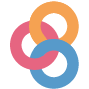)](https://mybinder.org/v2/gh/linogaliana/python-datascientist/master?filepath=notebooks/course/modelisation/4_featureselection.ipynb)
[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](http://colab.research.google.com/github/linogaliana/python-datascientist/blob/master/notebooks/course/modelisation/4_featureselection.ipynb)

Pour illustrer le travail de données nécessaire pour faire de la sélection de variable,
nous allons partir du même jeu de données que précédemment,
c'est-à-dire les résultats des élections US 2020 présentés dans l'[introduction
de cette partie](https://linogaliana-teaching.netlify.app/modelisation/): les données de vote aux élections présidentielles US
croisées à des variables socio-démographiques.
Le code 
est disponible [sur Github](https://github.com/linogaliana/python-datascientist/blob/master/content/modelisation/get_data.py)

Jusqu'à présent, nous avons supposé que les variables permettant d'éclairer le
vote Républicain étaient connues. Nous n'avons ainsi exploité qu'une partie
limitée de l'information disponible dans nos données. Néanmoins, outre le fléau
computationnel que représenterait la construction d'un modèle avec un grand
nombre de variable, le choix d'un nombre restreint de variables
(modèle parcimonieux) limite le risque de sur-apprentissage.

Comment, dès-lors, choisir le bon nombre de variables et la meilleure
combinaison de ces variables ? Il existe de multiples méthodes, parmi lesquelles :

* se fonder sur des critères statistiques de performance qui pénalisent les
modèles non parcimonieux. Par exemple, le BIC
* techniques de *backward elimination*
* construire des modèles pour lesquels la statistique d'intérêt pénalise l'absence
de parcimonie. 

La classe des modèles de *feature selection* est ainsi très vaste et regroupe
un ensemble très diverse de modèles. Nous allons nous focaliser sur le LASSO
(*Least Absolute Shrinkage and Selection Operator*)
qui est une extension de la régression linéaire qui vise à sélectionner des
modèles *sparses*. Ce type de modèle est central dans le champ du 
*Compressed sensing* (où on emploie plutôt le terme 
de *L1-regularization* que de LASSO). Le LASSO est un cas particulier des
régressions elastic-net dont un autre cas fameux est la régression *ridge*.
Contrairement à la régression linéaire classique, elles fonctionnent également
dans un cadre où $p>N$, c'est à dire où le nombre de régresseur est supérieur
au nombre d'observations.

# Données utilisées

On continue à utiliser les données de vote US. 


# Principe du LASSO

En adoptant le principe d'une fonction objectif pénalisée,
le LASSO permet de fixer un certain nombre de coefficients à 0.
Les variables dont la norme est non nulle passent ainsi le test de sélection. 

Le LASSO est un programme d'optimisation sous contrainte. On cherche à trouver l'estimateur $\beta$ qui minimise l'erreur quadratique (régression linéaire) sous une contrainte additionnelle régularisant les paramètres:
$$
\min_{\beta} \frac{1}{2}\mathbb{E}\bigg( \big( X\beta - y  \big)^2 \bigg) \\
\text{s.t. } \sum_{j=1}^p |\beta_j| \leq t
$$
Ce programme se reformule grâce au Lagrangien est permet ainsi d'obtenir un programme de minimisation plus maniable: 
$$
\beta^{\text{LASSO}} = \arg \min_{\beta} \frac{1}{2}\mathbb{E}\bigg( \big( X\beta - y  \big)^2 \bigg) + \alpha \sum_{j=1}^p |\beta_j| = \arg \min_{\beta} ||y-X\beta||_{2}^{2} + \alpha ||\beta||_1
$$
où $\lambda$ est une réécriture de la régularisation précédente. 

warning: sélection de variables corrélées

## Première régression LASSO

Avant de se lancer dans les exercices, on va éliminer quelques colonnes redondantes, 
celles qui concernent les votes des parties concurrents (forcément très
corrélés au vote Républicain...)  :


In [ ]:
df2 = votes.loc[:,~votes.columns.str.endswith(('_democrat','_green','_other', 'per_point_diff', 'per_dem'))]

1. Standardiser les variables. :warning: Avant ça,
ne garder que les colonnes numériques (idéalement on transformerait
les variables non numériques en numériques)
2. Estimer un modèle LASSO avec $alpha$=0.25. Afficher les valeurs des coefficients: qu'en déduire sur le modèle idéal ? Quelle variable a une valeur non nulle ?
3. Faire une régression linéaire avec le modèle parcimonieux et comparer la
performance à un modèle avec plus de variables

```
## /opt/conda/envs/python-ENSAE/lib/python3.9/site-packages/pandas/core/frame.py:5233: SettingWithCopyWarning:
## 
## 
## A value is trying to be set on a copy of a slice from a DataFrame
## 
## See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
```

Les coefficients estimés sont ainsi les suivants:

```
## array([0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
##        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 1.59154789e-02,
##        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
##        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
##        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
##        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
##        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
##        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
##        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
##        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
##        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
##        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
##        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
##        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
##        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
##        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
##        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
##        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
##        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
##        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
##        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
##        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
##        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
##        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
##        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
##        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
##        0.00000000e+00, 0.00000000e+00, 3.45685121e-02, 0.00000000e+00,
##        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
##        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
##        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
##        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
##        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
##        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
##        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
##        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
##        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
##        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
##        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
##        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
##        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
##        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
##        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
##        0.00000000e+00, 2.37849357e-02, 0.00000000e+00, 0.00000000e+00,
##        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
##        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
##        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
##        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
##        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
##        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
##        2.81116083e-01, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
##        0.00000000e+00, 0.00000000e+00, 4.07780300e-02, 0.00000000e+00,
##        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
##        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
##        4.86572240e-03, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
##        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
##        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
##        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
##        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
##        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
##        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
##        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
##        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
##        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
##        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
##        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
##        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
##        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 7.35522594e-02,
##        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
##        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
##        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
##        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
##        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
##        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
##        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
##        0.00000000e+00, 0.00000000e+00, 3.33445111e-06, 0.00000000e+00,
##        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
##        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
##        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
##        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
##        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
##        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
##        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
##        0.00000000e+00])
```

Le modèle est donc extrêmement parcimonieux puisque, avec le paramètre par défaut, seulement une variable explicative est sélectionnée. La variable sélectionnée est


In [ ]:
df2.select_dtypes(include=np.number).drop("per_gop", axis = 1).columns[np.abs(lasso1.coef_)>0]

```
## Index(['Rural-urban_Continuum Code_2003', 'GQ_ESTIMATES_2011',
##        '2003 Rural-urban Continuum Code',
##        'Percent of adults with a bachelor's degree or higher, 1990',
##        'Percent of adults with a high school diploma only, 2000',
##        'Percent of adults with a bachelor's degree or higher, 2015-19',
##        'Unemployment_rate_2012', 'Rural-urban_Continuum_Code_2003'],
##       dtype='object')
```

Autrement dit, le meilleur prédicteur pour le score des Républicains en 2020 est... le score des Républicains (et mécaniquement des démocrates) en 2016.
D'ailleurs, cette information est de loin la meilleure pour prédire le score 
des Républicains au point que si on tente de faire varier $\alpha$, un 
hyperparamètre du LASSO, on continuera à ne sélectionner qu'une seule variable



In [ ]:
import statsmodels.api as sm

```
## Error in py_call_impl(callable, dots$args, dots$keywords): ModuleNotFoundError: No module named 'statsmodels'
## 
## Detailed traceback: 
##   File "<string>", line 1, in <module>
```

In [ ]:
import statsmodels.formula.api as smf

```
## Error in py_call_impl(callable, dots$args, dots$keywords): ModuleNotFoundError: No module named 'statsmodels'
## 
## Detailed traceback: 
##   File "<string>", line 1, in <module>
```

In [ ]:
print(smf.ols("per_gop ~ share_2016_republican", data = df2).fit().summary())

```
## Error in py_call_impl(callable, dots$args, dots$keywords): NameError: name 'smf' is not defined
## 
## Detailed traceback: 
##   File "<string>", line 1, in <module>
```

La performance du modèle est déjà très bonne, avec une seule variable explicative.

Pour la suite, on va ainsi se contenter de variables moins bonnes mais qui 
présentent un intérêt pour la sélection.


## Effet du paramètre de pénalisation sur la sélection de variables

1. Utiliser la fonction `lasso_path` pour évaluer le nombre de paramètres sélectionnés par LASSO lorsque $\alpha$
varie (parcourir $[0,1]$ pour les valeurs de $\alpha$)
2. Regarder les paramètres qui sont sélectionnés pour, par exemple, $\alpha=0.1$




```
## <Figure size 700x700 with 0 Axes>
```

```
## [Text(0.5, 1.0, 'Number variables and regularization parameter ($\\alpha$)'), Text(0.5, 0, '$\\alpha$'), Text(0, 0.5, 'Nb. de variables')]
```



```
## /opt/conda/envs/python-ENSAE/lib/python3.9/site-packages/pandas/core/frame.py:5233: SettingWithCopyWarning:
## 
## 
## A value is trying to be set on a copy of a slice from a DataFrame
## 
## See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
```

Les variables sélectionnées, lorsque $\alpha = 0.2$, sont les suivantes:

```
## Index(['Rural-urban_Continuum Code_2003', 'GQ_ESTIMATES_2011',
##        '2003 Rural-urban Continuum Code',
##        'Percent of adults with a bachelor's degree or higher, 1990',
##        'Percent of adults with a high school diploma only, 2000',
##        'Percent of adults with a bachelor's degree or higher, 2015-19',
##        'Unemployment_rate_2012', 'Rural-urban_Continuum_Code_2003'],
##       dtype='object')
```

On voit ici que le LASSO sélectionne plus de variables. Quelques remarques :

* Certaines variables font sens, comme les variables
d'éducation par exemple ;
* On sélectionne des variables redondantes. Une phase plus approfondie de
nettoyage des données serait nécessaire ;
* On sélectionne des variables très corrélées




## Validation croisée pour sélectionner le modèle

Faut-il privilégier le modèle où $\alpha = 1$ ou $\alpha = 0.1$ ? Pour cela, 
il convient d'effectuer une validation croisée afin de prendre le modèle pour
lequel les variables qui passent la phase de sélection permettent de mieux 
prédire le résultat Républicain.



```
## 0.001
```




```
## Index(['Rural-urban_Continuum Code_2003', 'GQ_ESTIMATES_2011',
##        '2003 Rural-urban Continuum Code',
##        'Percent of adults with a bachelor's degree or higher, 1990',
##        'Percent of adults with a high school diploma only, 2000',
##        'Percent of adults with a bachelor's degree or higher, 2015-19',
##        'Unemployment_rate_2012', 'Rural-urban_Continuum_Code_2003'],
##       dtype='object')
```

ce qui correspond à un modèle avec 8 variables sélectionnées. C'est sans aucun doute trop peu parcimonieux : il faudrait revoir la phase de définition des variables pertinentes pour comprendre si des échelles différentes de certaines variables ne seraient pas plus appropriées (par exemple du `log`). 